<div style="background-color: #fff0f5; padding: 15px; border-radius: 8px; border-left: 5px solid #ff69b4;">
    <p style="color:#ff69b4; font-family: 'Comic Sans MS', cursive; font-size: 22px; font-weight: bold; margin: 0;">
    Import Required Libraries
    </p>
</div>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from datetime import datetime


<div style="background-color: #fff0f5; padding: 15px; border-radius: 8px; border-left: 5px solid #ff69b4;">
    <p style="color:#ff69b4; font-family: 'Comic Sans MS', cursive; font-size: 22px; font-weight: bold; margin: 0;">
    Define File Path
    </p>
</div>

In [2]:
# Set the file path to the dataset
filepath = '../data/newMed_events.csv'

<div style="background-color: #fff0f5; padding: 15px; border-radius: 8px; border-left: 5px solid #ff69b4;">
    <p style="color:#ff69b4; font-family: 'Comic Sans MS', cursive; font-size: 22px; font-weight: bold; margin: 0;">
    Load and Clean Data
    </p>
</div>

In [20]:
def load_and_clean_data(filepath):
    df = pd.read_csv(filepath, parse_dates=['eksd'])
    df['eksd'] = pd.to_datetime(df['eksd'], format='%Y-%m-%d')
    df.dropna(subset=['eksd', 'pnr'], inplace=True)
    return df


<div style="background-color: #f0f8ff; padding: 15px; border-radius: 8px; border-left: 5px solid #4CAF50;"> <p style="font-size: 20px; color: #4CAF50; font-weight: bold;">✅ What this does:</p> <ul style="font-size: 16px; color: #333; line-height: 1.6;"> <li>Loads and cleans the data from the CSV file.</li> <li><strong>Steps:</strong></li> <ul> <li>Reads the dataset from the specified <code>filepath</code>.</li> <li>Converts the <code>'eksd'</code> column (event date) to a <code>datetime</code> format.</li> <li>Removes any rows with missing values in the <code>'eksd'</code> or <code>'pnr'</code> columns.</li> </ul> <li><strong>Returns:</strong> A cleaned DataFrame ready for further processing.</li> </ul> </div>

<div style="background-color: #fff0f5; padding: 15px; border-radius: 8px; border-left: 5px solid #ff69b4;">
    <p style="color:#ff69b4; font-family: 'Comic Sans MS', cursive; font-size: 22px; font-weight: bold; margin: 0;">
    Preprocess Data for Specific ATC Code
    </p>
</div>

In [21]:
def preprocess_data(tidy, atc_code):
    subset = tidy[tidy['ATC'] == atc_code].sort_values(by=['pnr', 'eksd'])
    subset['prev_eksd'] = subset.groupby('pnr')['eksd'].shift(1)
    subset.dropna(subset=['prev_eksd'], inplace=True)
    return subset[['pnr', 'eksd', 'prev_eksd']]


<div style="background-color: #f0f8ff; padding: 15px; border-radius: 8px; border-left: 5px solid #4CAF50;"> <p style="font-size: 20px; color: #4CAF50; font-weight: bold;">✅ What this does:</p> <ul style="font-size: 16px; color: #333; line-height: 1.6;"> <li>Filters the data for a specific ATC code and prepares it for further analysis.</li> <li><strong>Steps:</strong></li> <ul> <li>Filters the data for the specified <code>atc_code</code>.</li> <li>Sorts the filtered data by <code>'pnr'</code> (patient number) and <code>'eksd'</code> (event date).</li> <li>Creates a new column <code>'prev_eksd'</code> to store the previous event date for each patient.</li> <li>Removes rows with missing <code>'prev_eksd'</code> values.</li> </ul> <li><strong>Returns:</strong> A subset of the data with patient event details, including the previous event date.</li> </ul> </div>

<div style="background-color: #fff0f5; padding: 15px; border-radius: 8px; border-left: 5px solid #ff69b4;">
    <p style="color:#ff69b4; font-family: 'Comic Sans MS', cursive; font-size: 22px; font-weight: bold; margin: 0;">
    Compute Event Intervals
    </p>
</div>

In [22]:
def compute_event_intervals(subset):
    subset['event.interval'] = (subset['eksd'] - subset['prev_eksd']).dt.days
    return subset


<div style="background-color: #f0f8ff; padding: 15px; border-radius: 8px; border-left: 5px solid #4CAF50;"> <p style="font-size: 20px; color: #4CAF50; font-weight: bold;">✅ What this does:</p> <ul style="font-size: 16px; color: #333; line-height: 1.6;"> <li>Calculates the event intervals for each patient.</li> <li><strong>Steps:</strong></li> <ul> <li>Computes the time difference between the current event (<code>eksd</code>) and the previous event (<code>prev_eksd</code>) for each patient.</li> <li>Stores the result as the <code>event.interval</code> column in the DataFrame, in days.</li> </ul> <li><strong>Returns:</strong> A DataFrame with the computed event intervals for each patient.</li> </ul> </div>

<div style="background-color: #fff0f5; padding: 15px; border-radius: 8px; border-left: 5px solid #ff69b4;">
    <p style="color:#ff69b4; font-family: 'Comic Sans MS', cursive; font-size: 22px; font-weight: bold; margin: 0;">
    Compute ECDF (Empirical Cumulative Distribution Function)
    </p>
</div>

In [6]:
def compute_ecdf(data):
    sorted_intervals = np.sort(data['event.interval'].values)
    yvals = np.arange(1, len(sorted_intervals) + 1) / len(sorted_intervals)
    return pd.DataFrame({'x': sorted_intervals, 'y': yvals})


<div style="background-color: #f0f8ff; padding: 15px; border-radius: 8px; border-left: 5px solid #4CAF50;"> <p style="font-size: 20px; color: #4CAF50; font-weight: bold;">✅ What this does:</p> <ul style="font-size: 16px; color: #333; line-height: 1.6;"> <li>Computes the Empirical Cumulative Distribution Function (ECDF) for the event intervals.</li> <li><strong>Steps:</strong></li> <ul> <li>Sorts the event intervals.</li> <li>Calculates the cumulative probability for each sorted event interval.</li> </ul> <li><strong>Returns:</strong> A DataFrame with the sorted event intervals and their corresponding cumulative probabilities.</li> </ul> </div>

<div style="background-color: #fff0f5; padding: 15px; border-radius: 8px; border-left: 5px solid #ff69b4;">
    <p style="color:#ff69b4; font-family: 'Comic Sans MS', cursive; font-size: 22px; font-weight: bold; margin: 0;">
    Perform DBSCAN Clustering
    </p>
</div>

In [23]:
def dbscan_clustering(dfper, eps=0.5, min_samples=5):
    X = dfper[['x']].values
    X_scaled = StandardScaler().fit_transform(X)
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X_scaled)
    dfper['cluster'] = labels
    return dfper



<div style="background-color: #f0f8ff; padding: 15px; border-radius: 8px; border-left: 5px solid #4CAF50;"> <p style="font-size: 20px; color: #4CAF50; font-weight: bold;">✅ What this does:</p> <ul style="font-size: 16px; color: #333; line-height: 1.6;"> <li>Applies DBSCAN clustering on the event intervals to group similar data points.</li> <li><strong>Steps:</strong></li> <ul> <li>Standardizes the 'x' values (event intervals) using <code>StandardScaler</code> to ensure all features contribute equally to the clustering process.</li> <li>Uses the DBSCAN algorithm with the given <code>eps</code> and <code>min_samples</code> parameters to identify clusters in the data.</li> <li>Assigns a cluster label to each data point in the <code>'cluster'</code> column.</li> </ul> <li><strong>Returns:</strong> A DataFrame with the clustering results, including the cluster labels for each event interval.</li> </ul> </div>

<div style="background-color: #fff0f5; padding: 15px; border-radius: 8px; border-left: 5px solid #ff69b4;">
    <p style="color:#ff69b4; font-family: 'Comic Sans MS', cursive; font-size: 22px; font-weight: bold; margin: 0;">
    Assign Clusters Based on Event Intervals
    </p>
</div>

In [24]:
def assign_clusters(event_data, dfper):
    dfper = dfper[dfper['x'] > 0]
    if dfper.empty:
        print("Warning: dfper has no valid values after removing zeros.")
        return event_data

    dfper = dfper.copy()
    dfper['log_x'] = np.log(dfper['x'])
    summary = dfper.groupby('cluster')['log_x'].agg(['min', 'max', 'median']).reset_index()
    summary[['Minimum', 'Maximum', 'Median']] = np.exp(summary[['min', 'max', 'median']])

    if 'cluster' not in event_data.columns:
        event_data['cluster'] = 0

    event_data = event_data.merge(summary[['cluster', 'Minimum', 'Maximum']], how='left', on='cluster')
    event_data[['Minimum', 'Maximum']] = event_data[['Minimum', 'Maximum']].fillna(0)

    event_data['cluster'] = np.where((event_data['event.interval'] >= event_data['Minimum']) &
                                     (event_data['event.interval'] <= event_data['Maximum']),
                                     event_data['cluster'], 0)
    return event_data



<div style="background-color: #f0f8ff; padding: 15px; border-radius: 8px; border-left: 5px solid #4CAF50;"> <p style="font-size: 20px; color: #4CAF50; font-weight: bold;">✅ What this does:</p> <ul style="font-size: 16px; color: #333; line-height: 1.6;"> <li>Assigns the appropriate cluster to each event data point based on its event interval.</li> <li><strong>Steps:</strong></li> <ul> <li>Filters out event intervals less than or equal to zero.</li> <li>Calculates the natural log of the event intervals and adds it as a new column (<code>log_x</code>) for analysis.</li> <li>Computes the minimum, maximum, and median log-transformed event intervals for each cluster.</li> <li>Joins this information with the event data and filters based on the defined cluster ranges.</li> </ul> <li><strong>Returns:</strong> The event data with assigned cluster labels, based on the computed event intervals.</li> </ul> </div>

<div style="background-color: #fff0f5; padding: 15px; border-radius: 8px; border-left: 5px solid #ff69b4;">
    <p style="color:#ff69b4; font-family: 'Comic Sans MS', cursive; font-size: 22px; font-weight: bold; margin: 0;">
    Plot ECDF for 80% and 100% Event Intervals
    </p>
</div>

In [25]:
def plot_ecdf(filtered_percentile, empirical_cdf):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].plot(filtered_percentile["x"], filtered_percentile["y"], label="80% ECDF", color='#D15F9A')
    axes[0].set(title="80% ECDF", xlabel="Event Interval", ylabel="Cumulative Probability")

    axes[1].plot(empirical_cdf.x, empirical_cdf.y, label="100% ECDF", color='#9B4F96')
    axes[1].set(title="100% ECDF", xlabel="Event Interval", ylabel="Cumulative Probability")

    plt.tight_layout()
    plt.show()



<div style="background-color: #f0f8ff; padding: 15px; border-radius: 8px; border-left: 5px solid #4CAF50;"> <p style="font-size: 20px; color: #4CAF50; font-weight: bold;">✅ What this does:</p> <ul style="font-size: 16px; color: #333; line-height: 1.6;"> <li>Plots the ECDF (Empirical Cumulative Distribution Function) for both the filtered 80% percentile and the entire dataset.</li> <li><strong>Steps:</strong></li> <ul> <li>Plots the ECDF of the filtered dataset (80% of the data) on the first subplot.</li> <li>Plots the ECDF of the full dataset (100%) on the second subplot.</li> </ul> <li><strong>Returns:</strong> Displays the ECDF plots showing the cumulative distribution of event intervals.</li> </ul> </div>

<div style="background-color: #fff0f5; padding: 15px; border-radius: 8px; border-left: 5px solid #ff69b4;">
    <p style="color:#ff69b4; font-family: 'Comic Sans MS', cursive; font-size: 22px; font-weight: bold; margin: 0;">
    Plot KDE (Kernel Density Estimate)
    </p>
</div>

In [26]:
def plot_kde(filtered_percentile):
    eps = 1e-6
    
    filtered_percentile = filtered_percentile[filtered_percentile["x"] > 0].copy()
    
    log_transformed_x = np.log(filtered_percentile["x"] + eps)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.kdeplot(log_transformed_x, label="Log(event interval)", fill=True, color='#C86EAC', ax=ax)
    
    ax.set(title="Log(Event Interval) KDE", xlabel="Log(Event Interval)", ylabel="Density")
    plt.show()

    return log_transformed_x

<div style="background-color: #f0f8ff; padding: 15px; border-radius: 8px; border-left: 5px solid #4CAF50;"> <p style="font-size: 20px; color: #4CAF50; font-weight: bold;">✅ What this does:</p> <ul style="font-size: 16px; color: #333; line-height: 1.6;"> <li>Plots the Kernel Density Estimate (KDE) of the log-transformed event intervals.</li> <li><strong>Steps:</strong></li> <ul> <li>Filters out event intervals less than or equal to zero.</li> <li>Applies a natural logarithm transformation to the event intervals for a more normal-like distribution.</li> <li>Plots the KDE of the log-transformed event intervals to visualize the density distribution.</li> </ul> <li><strong>Returns:</strong> Displays the KDE plot and returns the log-transformed event intervals.</li> </ul> </div>

<div style="background-color: #fff0f5; padding: 15px; border-radius: 8px; border-left: 5px solid #ff69b4;">
    <p style="color:#ff69b4; font-family: 'Comic Sans MS', cursive; font-size: 22px; font-weight: bold; margin: 0;">
    Main Function to Process and Visualize DBSCAN Clustering
    </p>
</div>

In [27]:
def see_dbscan(atc_code, tidy, eps=0.5, min_samples=5):
    event_data = preprocess_data(tidy, atc_code)
    event_data = compute_event_intervals(event_data)
    dfper = compute_ecdf(event_data)
    dfper_80 = dfper[dfper['y'] <= 0.8]
    plot_ecdf(dfper_80, dfper)
    dfper = dbscan_clustering(dfper, eps=eps, min_samples=min_samples)
    plot_kde(dfper_80)
    return assign_clusters(event_data, dfper)


<div style="background-color: #fff0f5; padding: 15px; border-radius: 8px; border-left: 5px solid #ff69b4;">
    <p style="color:#ff69b4; font-family: 'Comic Sans MS', cursive; font-size: 22px; font-weight: bold; margin: 0;">
    Visualize Assumptions on Event Duration by Patient Number
    </p>
</div>

In [29]:
def see_assumption(data):
    data.sort_values(by=['pnr', 'eksd'], inplace=True)
    data['prev_eksd'] = data.groupby('pnr')['eksd'].shift(1)
    data['p_number'] = data.groupby('pnr').cumcount() + 1
    filtered_data = data[data['p_number'] >= 2].copy()
    filtered_data['Duration'] = (filtered_data['eksd'] - filtered_data['prev_eksd']).dt.days

    fig, ax = plt.subplots(figsize=(12, 6))
    sns.set(style="whitegrid")
    sns.boxplot(x='p_number', y='Duration', data=filtered_data, ax=ax, hue='p_number', palette="muted", legend=False)

    ax.set_title('Event Duration by Patient Number', fontsize=16, fontweight='bold')
    ax.set_xlabel('Patient Number', fontsize=14)
    ax.set_ylabel('Duration (Days)', fontsize=14)
    ax.tick_params(axis='both', labelsize=12)

    plt.tight_layout()
    plt.show()
    return fig


<div style="background-color: #fff0f5; padding: 15px; border-radius: 8px; border-left: 5px solid #ff69b4;">
    <p style="color:#ff69b4; font-family: 'Comic Sans MS', cursive; font-size: 22px; font-weight: bold; margin: 0;">
    Load and Clean the Data
    </p>
</div>

In [30]:
# Load and clean the data
tidy = load_and_clean_data(filepath)

<div style="background-color: #fff0f5; padding: 15px; border-radius: 8px; border-left: 5px solid #ff69b4;">
    <p style="color:#ff69b4; font-family: 'Comic Sans MS', cursive; font-size: 22px; font-weight: bold; margin: 0;">
    DBSCAN Clustering of medA
    </p>
</div>

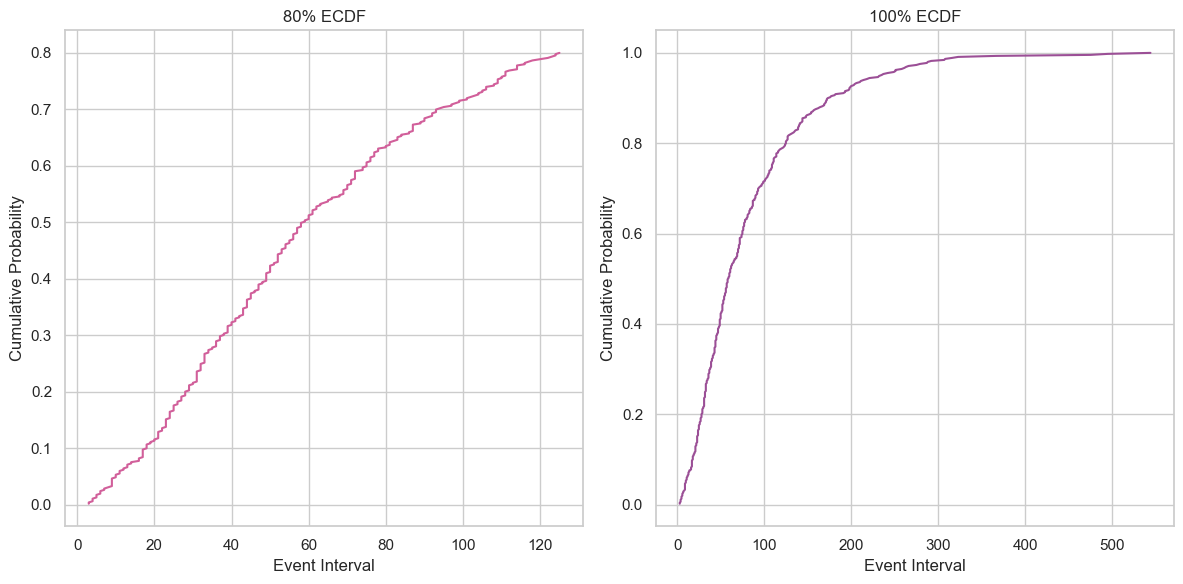

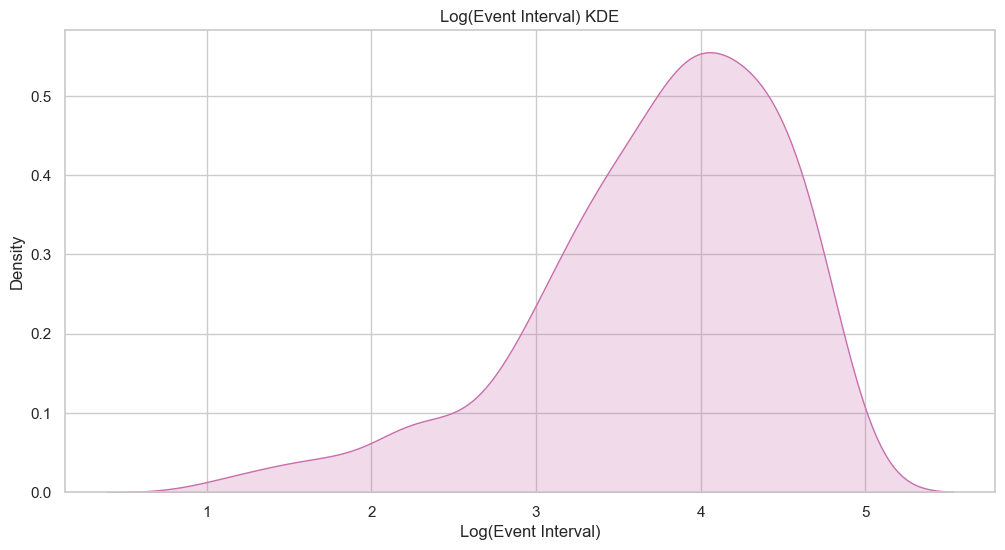

In [31]:
medA_clustered = see_dbscan('medA', tidy)

In [36]:
medA_clustered.head()

,pnr,eksd,prev_eksd,event.interval,cluster,Minimum,Maximum,p_number
0,2,2036-03-10,NaT,50,0,3.0,323.0,1
1,2,2036-08-01,2036-03-10,144,0,3.0,323.0,2
2,4,2032-11-27,NaT,210,0,3.0,323.0,1
3,4,2033-08-20,2032-11-27,266,0,3.0,323.0,2
4,4,2033-08-30,2033-08-20,10,0,3.0,323.0,3


<div style="background-color: #fff0f5; padding: 15px; border-radius: 8px; border-left: 5px solid #ff69b4;">
    <p style="color:#ff69b4; font-family: 'Comic Sans MS', cursive; font-size: 22px; font-weight: bold; margin: 0;">
    DBSCAN Clustering of medB
    </p>
</div>

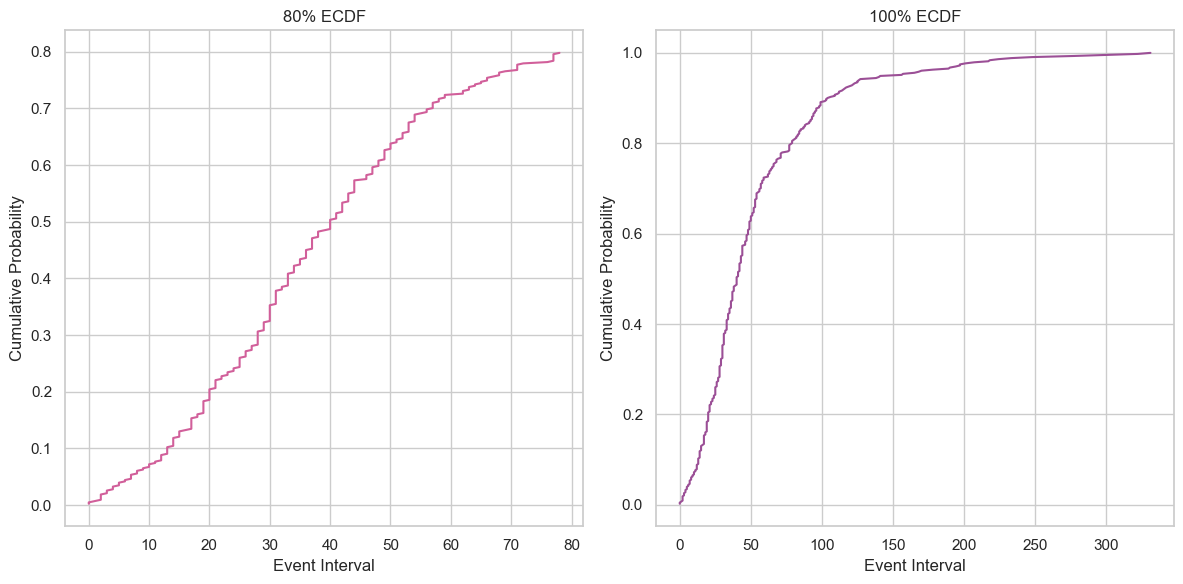

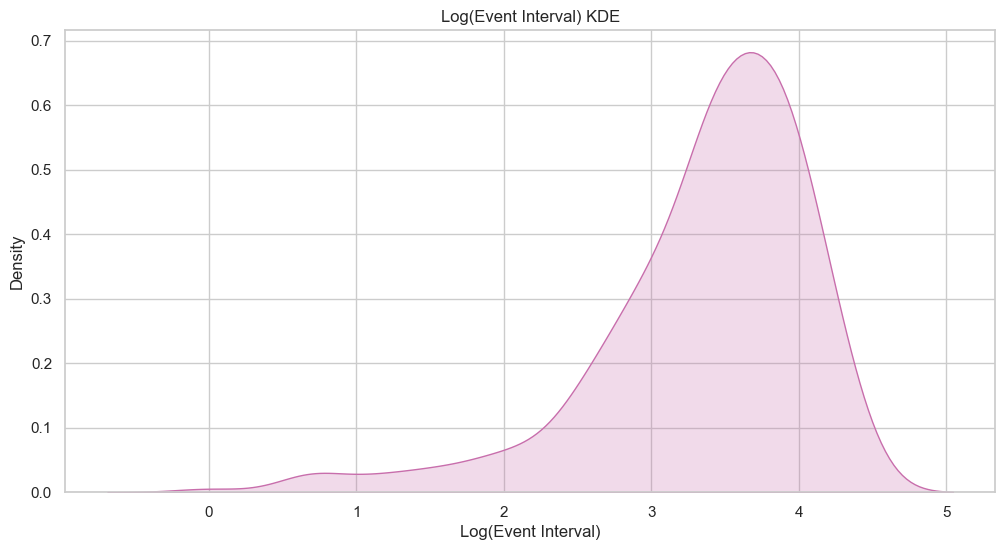

In [32]:
medB_clustered = see_dbscan('medB', tidy)

In [35]:
medB_clustered.head()

,pnr,eksd,prev_eksd,event.interval,cluster,Minimum,Maximum
0,1,2033-08-03,2033-07-04,30,0,1.0,248.0
1,1,2033-08-17,2033-08-03,14,0,1.0,248.0
2,1,2033-10-13,2033-08-17,57,0,1.0,248.0
3,1,2033-10-16,2033-10-13,3,0,1.0,248.0
4,1,2033-11-23,2033-10-16,38,0,1.0,248.0


<div style="background-color: #fff0f5; padding: 15px; border-radius: 8px; border-left: 5px solid #ff69b4;">
    <p style="color:#ff69b4; font-family: 'Comic Sans MS', cursive; font-size: 22px; font-weight: bold; margin: 0;">
    Assumption for DBSCAN Clustering of medA
    </p>
</div>

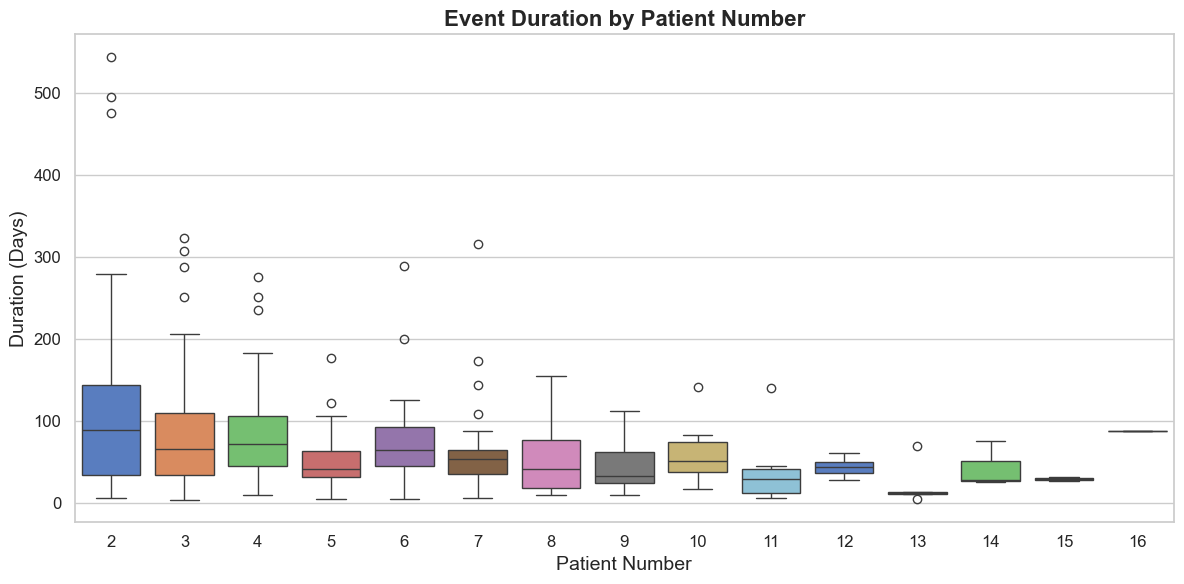

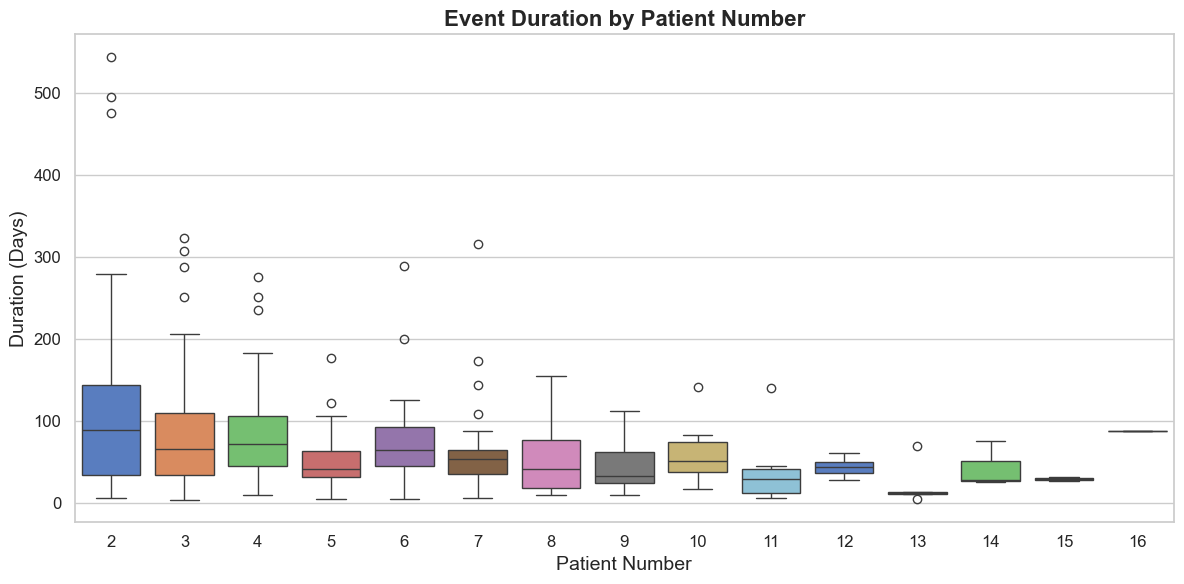

In [33]:
see_assumption(medA_clustered)

<div style="background-color: #fff0f5; padding: 15px; border-radius: 8px; border-left: 5px solid #ff69b4;">
    <p style="color:#ff69b4; font-family: 'Comic Sans MS', cursive; font-size: 22px; font-weight: bold; margin: 0;">
    Assumption for DBSCAN Clustering of medB
    </p>
</div>

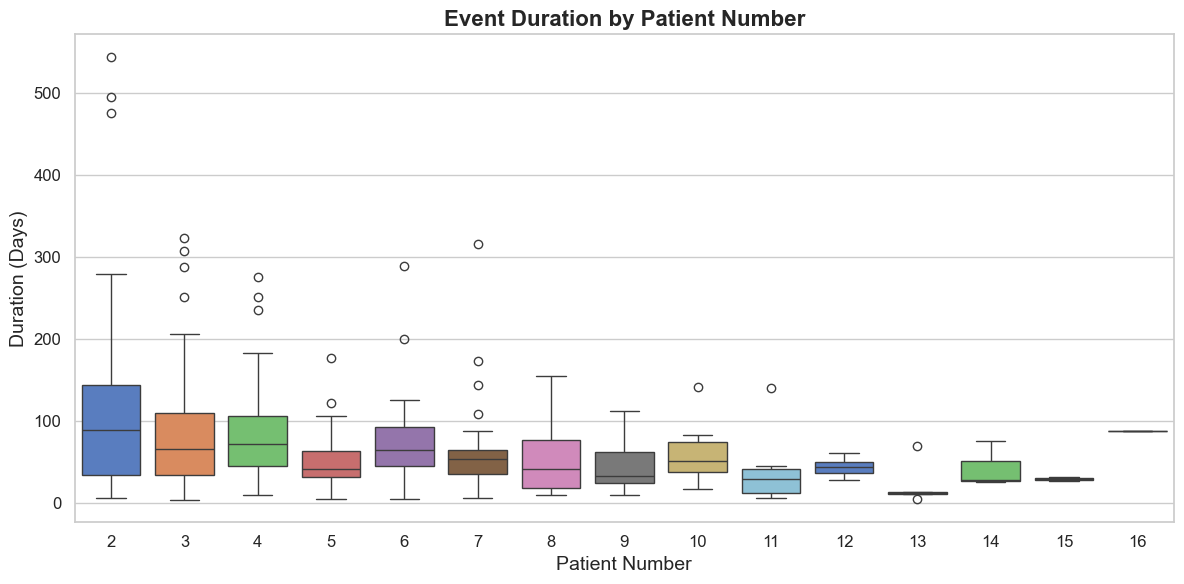

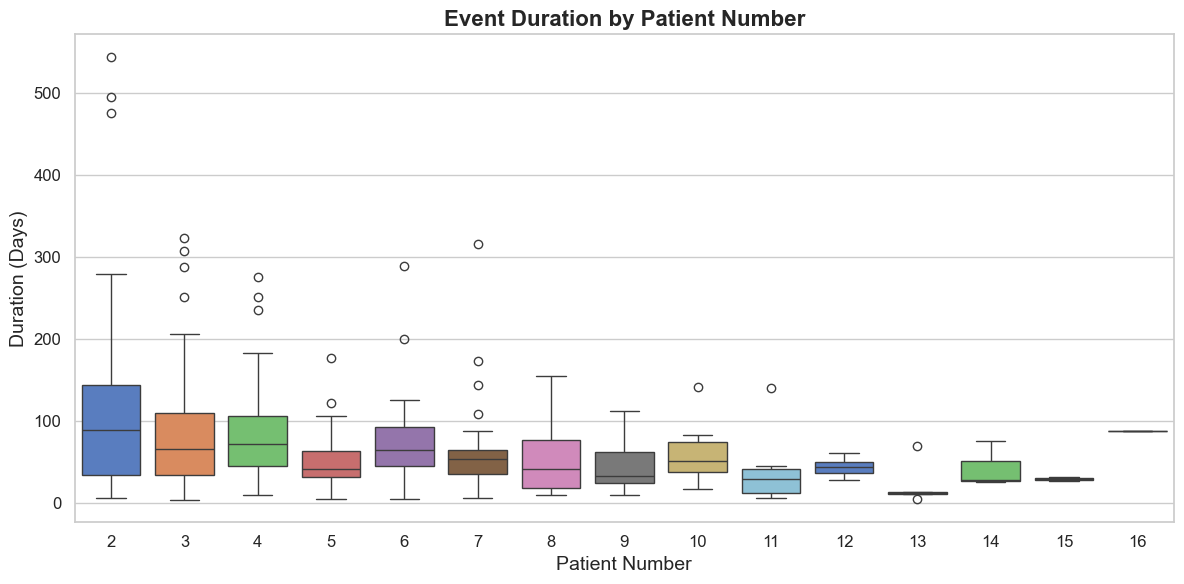

In [34]:
see_assumption(medA_clustered)